# 📈 Google Stock Price Forecasting Using LSTM

This project applies a Long Short-Term Memory (LSTM) neural network to forecast the closing price of **Google (GOOGL) stock** based on historical time-series data.  
LSTM models are widely used for sequence prediction tasks because they effectively capture long-range temporal dependencies, making them ideal for financial time series.

### 🎯 Project Objectives
- Load and analyze historical Google stock price data  
- Explore time-series patterns through visualization  
- Preprocess the data using normalization and windowed sequences  
- Build and train an LSTM-based deep learning model  
- Evaluate performance and forecast future closing prices  
- Visualize predictions vs. actual values  

### 🧠 Why LSTM?
Traditional models struggle with long-term dependencies in sequential data.  
LSTMs solve this through gated memory, enabling the model to:

- Remember important trends  
- Forget irrelevant noise  
- Capture complex nonlinear patterns  

This makes LSTM a strong baseline for financial forecasting tasks.

### 📂 Contents
1. Data Loading & Exploration  
2. Exploratory Visualization  
3. Preprocessing & Feature Scaling  
4. Sequence Window Creation  
5. LSTM Model Architecture  
6. Model Training  
7. Prediction & Visualization  
8. Discussion and Conclusions

---


In [1]:
# Importing libraries
import os
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
import warnings
# Suppressing warnings
warnings.filterwarnings('ignore')

In [3]:
# Setting random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

## 1. - Data Loading & Overview

In [4]:
# Loading Google stock price training data
training_set = pd.read_csv('Google_Stock_Price_Train.csv')
training_set.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [5]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [6]:
training_set.describe()

,Open,High,Low
count,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409
std,151.904442,153.008811,150.552807
min,279.120000,281.210000,277.220000
25%,404.115000,406.765000,401.765000
50%,537.470000,540.750000,532.990000
75%,654.922500,662.587500,644.800000
max,816.680000,816.680000,805.140000


In [7]:
training_set.tail()

,Date,Open,High,Low,Close,Volume
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"
1257,12/30/2016,782.75,782.78,770.41,771.82,"1,770,000"


In [8]:
# Checking for missing values 
training_set.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [9]:
# Removing commas from 'Close' and 'Volume' columns and converting them to numeric types
training_set['Close'] = training_set['Close'].str.replace(',', '').astype(float)
training_set['Volume'] = training_set['Volume'].str.replace(',', '').astype(int)

## 2. Exploratory Data Analysis - Time Series Visualization

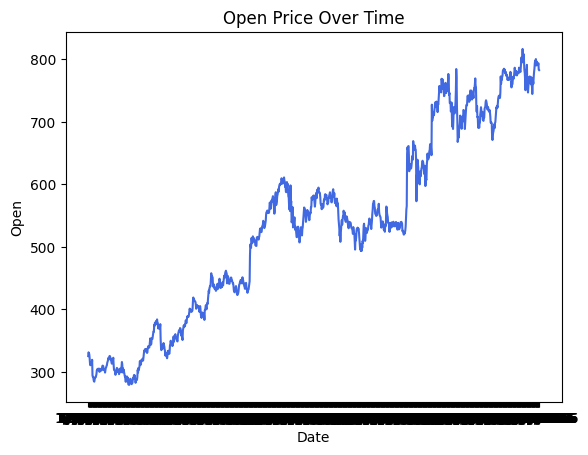

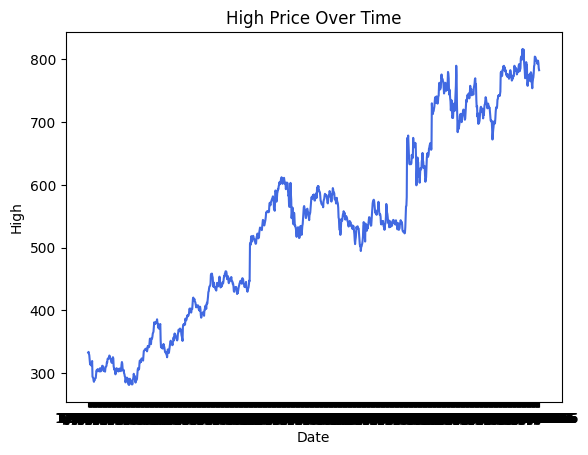

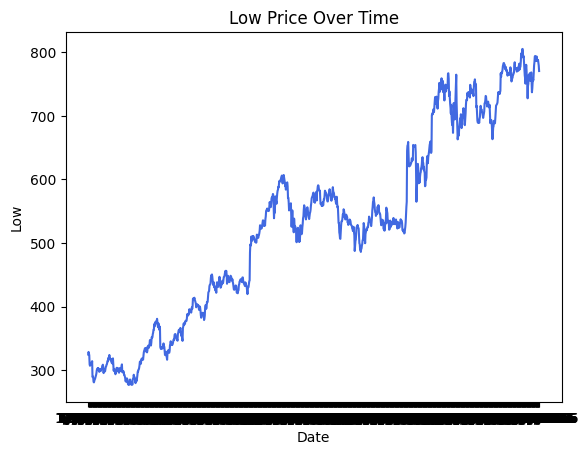

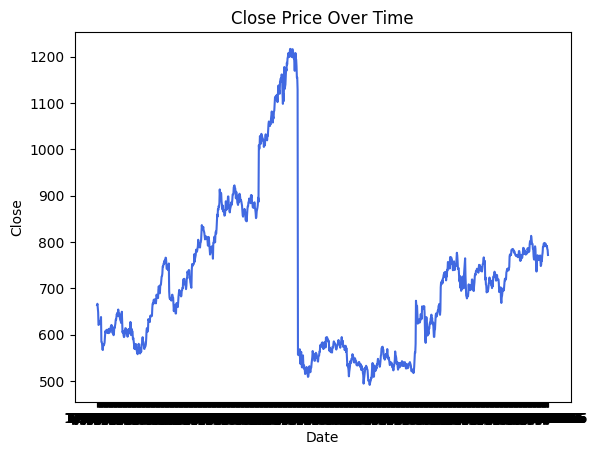

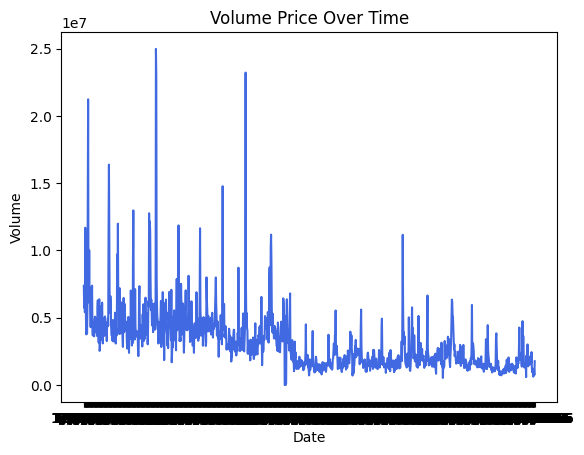

In [10]:
# Selecting all columns except 'Date' for visualization
cols = training_set.drop('Date', axis=1).columns

# Plotting each feature over time to observe trends and fluctuations
for col in cols:
    plt.plot(training_set['Date'], training_set[col], color='royalblue')
    plt.title(f'{col} Price Over Time')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.show()

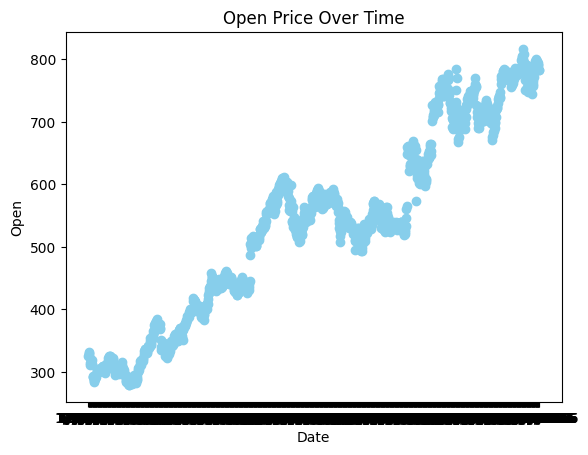

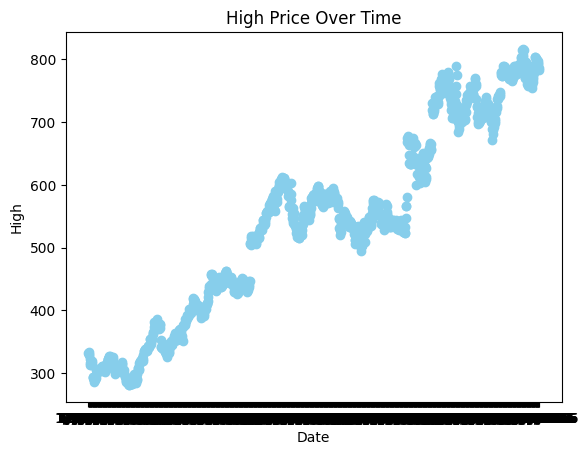

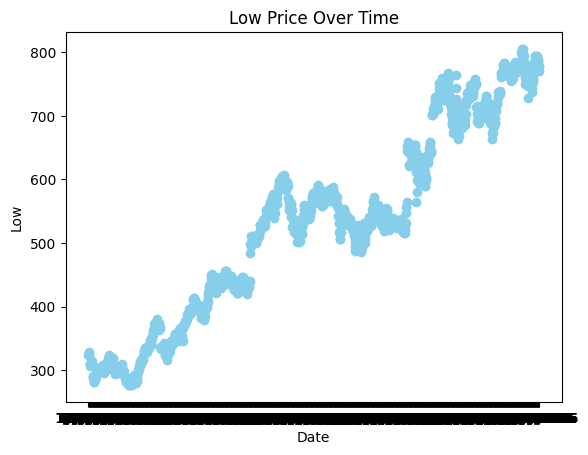

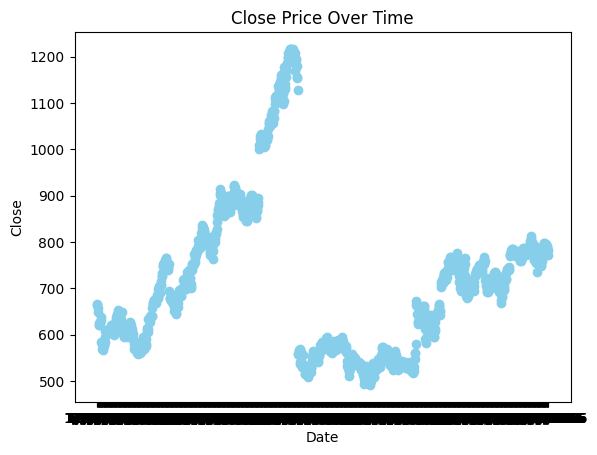

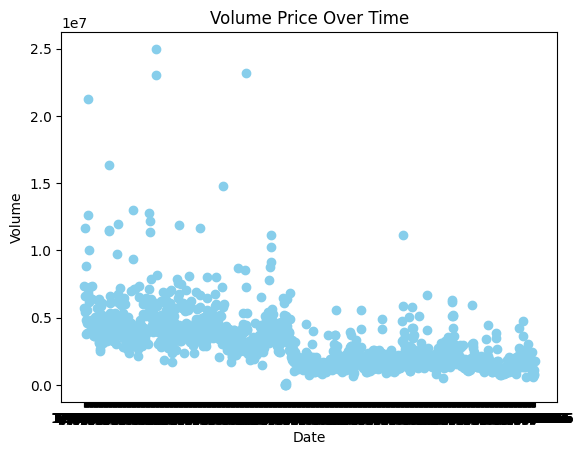

In [11]:
# Plotting scatter plots for each feature over time to observe individual data point distribution
for col in cols:
    plt.scatter(training_set['Date'], training_set[col], color='skyblue')
    plt.title(f'{col} Price Over Time')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.show()

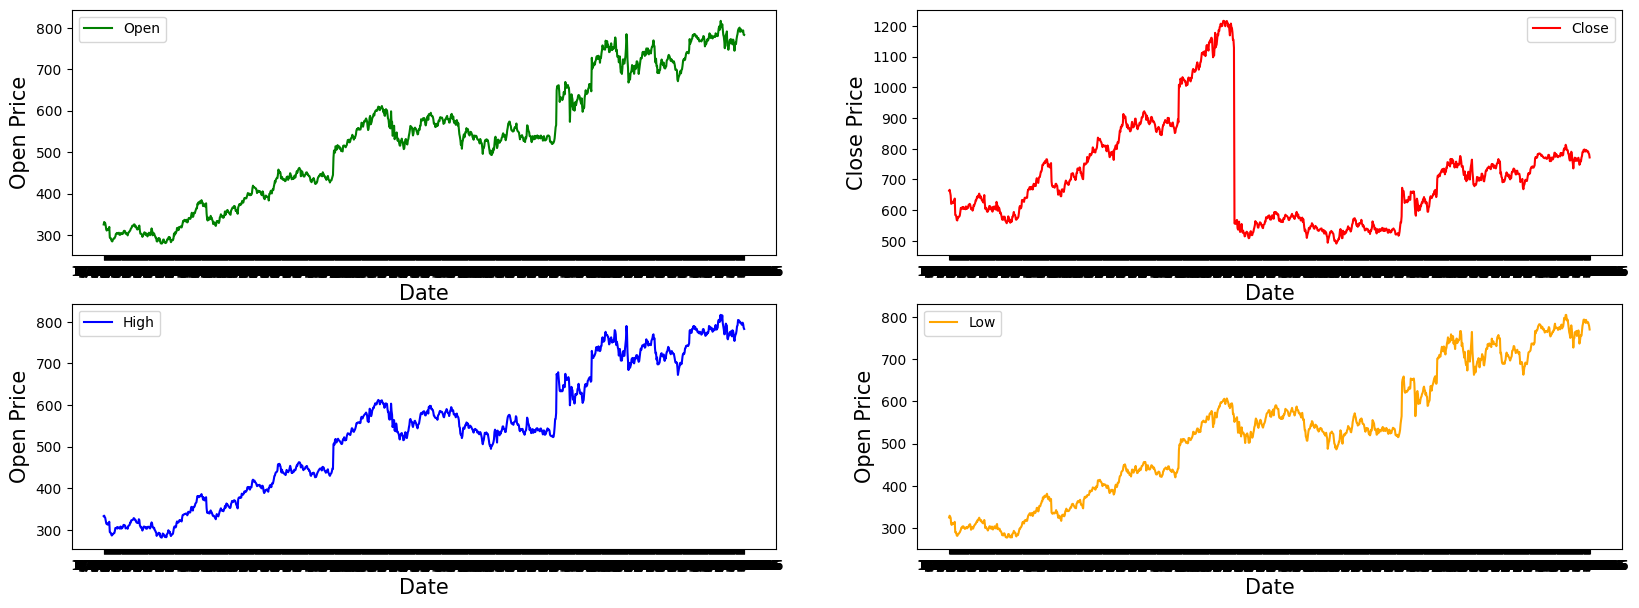

In [12]:
# Comparing price types over time
# Creating a 2x2 grid of subplots to visualize Open, Close, High, and Low prices over time
fig, ax =plt.subplots(2, 2, figsize=(20,7))

# Plotting 'Open' price in green
ax[0][0].plot(training_set['Date'], training_set['Open'], label='Open', color='green')
ax[0][0].set_xlabel('Date', size=15)
ax[0][0].set_ylabel('Open Price', size=15)
ax[0][0].legend()

# Plotting 'Close' price in red
ax[0][1].plot(training_set['Date'], training_set['Close'], label='Close', color='red')
ax[0][1].set_xlabel('Date', size=15)
ax[0][1].set_ylabel('Close Price', size=15)
ax[0][1].legend()

# Plotting 'High' price in blue
ax[1][0].plot(training_set['Date'], training_set['High'], label='High', color='blue')
ax[1][0].set_xlabel('Date', size=15)
ax[1][0].set_ylabel('Open Price', size=15)
ax[1][0].legend()

# Plotting 'Low' price in orange
ax[1][1].plot(training_set['Date'], training_set['Low'], label='Low', color='orange')
ax[1][1].set_xlabel('Date', size=15)
ax[1][1].set_ylabel('Open Price', size=15)
ax[1][1].legend()

fig.show()

Text(0.5, 1.0, 'Correlation Heatmap')

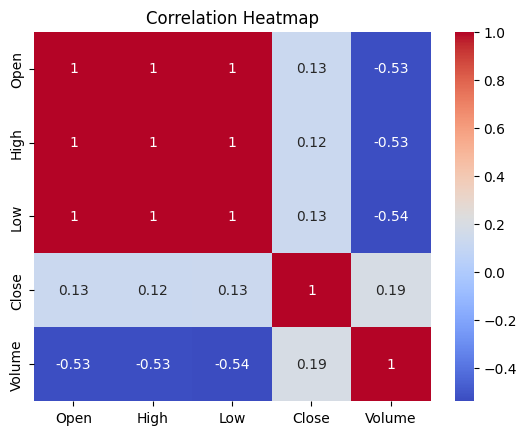

In [13]:
# Correlation heatmap
sns.heatmap(training_set.corr(numeric_only=True), cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap')

## 3. Data Preprocessing

In [14]:
# Extracting the 'Close' price column as the target feature for time series prediction
train = training_set.iloc[:, 4:5].values

In [15]:
# Feature scaling
sc = MinMaxScaler()
train_scaled = sc.fit_transform(train)

In [16]:
# Create a data structure with 60 timesteps and 1 output
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i, 0]) # Sequence of 60 previous values
        y.append(data[i, 0])           # Target value at current time step

    X = np.array(X)
    y = np.array(y)
    return X.reshape((X.shape[0], X.shape[1], 1)), y # Reshape for LSTM input format

X_train, y_train  = create_sequences(train_scaled)

## 4. Build and Train The LSTM

- Input layer defines the shape of each training sample
- Three LSTM layers with 60 units each capture temporal dependencies
- Dropout layers (rate = 0.2) reduce overfitting by randomly disabling neurons during training
- Final Dense layer outputs a single predicted value (e.g., next closing price)
- Compiled with Adam optimizer and mean squared error loss for regression

In [17]:
# Defining a function to build a stacked LSTM model for time series regression
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=60, return_sequences=True)) # The firts LSTM layer
    model.add(Dropout(0.2)) # Dropout regularisation

    model.add(LSTM(units=60, return_sequences=True)) # LSTM layer
    model.add(Dropout(0.2)) # Dropout regularisation

    model.add(LSTM(units=60)) # LSTM layer
    model.add(Dropout(0.2)) # Dropout regularisation

    model.add(Dense(units=1)) # Output layer

    # Compiled with Adam optimizer and mean squared error loss for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_lstm_model((X_train.shape[1], 1))

In [18]:
# Training the model on the prepared sequences
history = model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0278
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0084
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0062
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0055
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0052 
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0050 
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0050
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0053
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0048
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0044
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0045
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0041
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0037
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0033
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - 

## 5. Making Predictions

In [20]:
# Loading the test dataset
test_set = pd.read_csv('Google_Stock_Price_Test.csv')
actual_stock_price = test_set.iloc[:, 4:5].values

# Concatenating training and test sets to build input sequences for prediction
df = pd.concat((training_set, test_set), axis=0)

In [23]:
# Selecting the last 60 rows before the test set to generate input sequences
inputs = df.iloc[len(df)-len(test_set)-60:, 4:5].values

# Scaling inputs using the same scaler fitted on training data
inputs = sc.transform(inputs)

In [24]:
# Creating input sequences for prediction
X_test = []

for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)

In [25]:
# Generating predictions using the trained LSTM model
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step


## 6. RMSE Results

In [26]:
# Calculating Root Mean Squared Error (RMSE)
rmse = math.sqrt(mean_squared_error(actual_stock_price, predicted_stock_price))
rmse

10.654364831766372

## 7. Visualize The Results

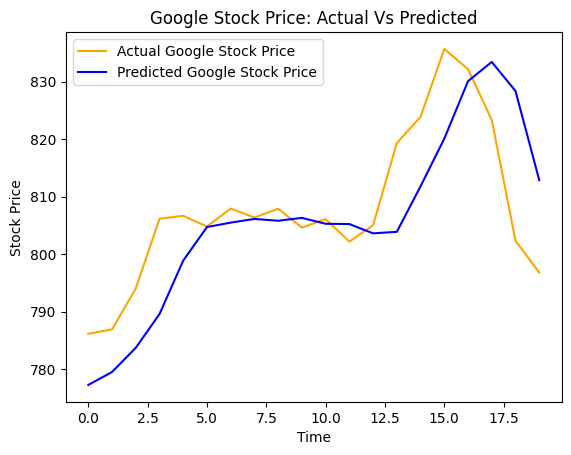

In [27]:
# Plotting actual and predicted Google stock prices to visually assess model performance
plt.plot(actual_stock_price, color='orange', label='Actual Google Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price: Actual Vs Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

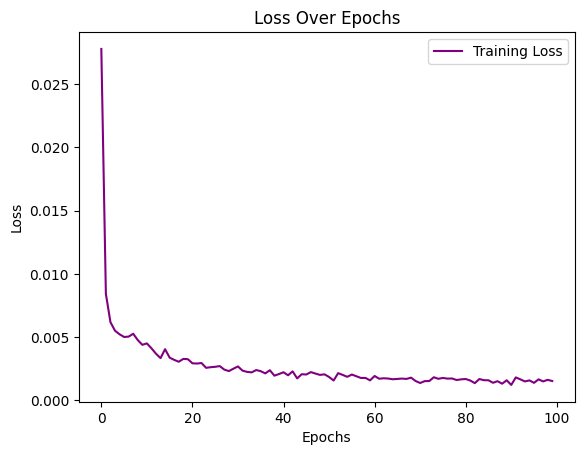

In [28]:
# Visualizing the training loss across epochs to monitor model convergence
plt.plot(history.history['loss'], color='purple', label='Training Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 🧾 Conclusion

In this project, we developed an LSTM-based deep learning model to forecast the closing price of Google (GOOGL) stock. The workflow included data preprocessing, sequence windowing, model training, and performance evaluation using both visual inspection and quantitative metrics.

### 📊 Model Performance

The model achieved an RMSE of **10.65**, indicating the average prediction error relative to the scale of Google’s stock price. This performance suggests that the LSTM was able to capture the primary trends and temporal dependencies within the data, performing reasonably well for short-term forecasting.

### ✅ Key Takeaways

- LSTMs are effective for modeling complex temporal relationships in financial time-series data.  
- Proper preprocessing—such as scaling and sequence creation—is crucial for stable training.  
- The model’s predictions align well with the overall stock price trajectory, despite natural market fluctuations.

### ⚠ Limitations

Despite producing trend-consistent predictions, this model faces several limitations:

- Financial markets are highly volatile and influenced by external events not present in historical data.  
- The model relies solely on past price data without technical indicators or sentiment data.  
- LSTMs can struggle with long-term forecasting due to compounding errors.

### 🚀 Future Enhancements

To improve predictive accuracy, the following extensions are recommended:

- Incorporate technical indicators (e.g., RSI, MACD, EMA).  
- Add macroeconomic or sentiment data for richer context.  
- Experiment with more modern architectures like GRUs or Transformers.  
- Perform hyperparameter tuning and cross-validation.  

Overall, the project demonstrates a strong baseline for stock price forecasting using deep learning and provides a solid foundation for more advanced future modeling.
